# Data Understanding and Feature Engineering for Container Price Prediction

This notebook performs comprehensive analysis of our collected data and engineers the time-lagged features necessary for accurate time-series forecasting of container freight prices.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load Data

Load the cleaned freight, black swan disruption data, and crude oil prices prepared in the data collection notebook.

In [2]:
# Load freight data
try:
    df_freight = pd.read_csv("collected_freight_data.csv", parse_dates=["Date"], index_col="Date")
    print(f" Loaded freight data: {len(df_freight)} records")
    print(f"  Date range: {df_freight.index.min().date()} to {df_freight.index.max().date()}")
except FileNotFoundError:
    print(" Error: collected_freight_data.csv not found. Run data collection notebook first.")

# Load black swan disruption data
try:
    df_news = pd.read_csv("collected_news_data.csv", parse_dates=["date"], index_col="date")
    has_news = True
    print(f" Loaded black swan data: {len(df_news)} records")
    print(f"  Features: {len(df_news.columns)} disruption indicators")
except FileNotFoundError:
    has_news = False
    print(" Error: collected_news_data.csv not found. Run data collection notebook first.")

# Load crude oil prices
try:
    df_oil = pd.read_csv("data/DCOILWTICO.csv", parse_dates=["observation_date"], index_col="observation_date")
    df_oil.rename(columns={"DCOILWTICO": "crude_oil_price"}, inplace=True)
    # Resample daily oil prices to weekly averages matching freight data (Fridays)
    df_oil_weekly = df_oil.resample('W-FRI').mean()
    has_oil = True
    print(f" Loaded crude oil data: {len(df_oil)} daily records")
    print(f"  Resampled to {len(df_oil_weekly)} weekly records")
    print(f"  Date range: {df_oil.index.min().date()} to {df_oil.index.max().date()}")
except FileNotFoundError:
    has_oil = False
    df_oil_weekly = None
    print(" Error: data/DCOILWTICO.csv not found.")

 Loaded freight data: 385 records
  Date range: 2018-01-05 to 2025-08-22
 Loaded black swan data: 407 records
  Features: 22 disruption indicators
 Loaded crude oil data: 1957 daily records
  Resampled to 392 weekly records
  Date range: 2018-01-02 to 2025-07-02


## Step 2: Merge Datasets and Create Target Variable

Perform inner join on date index and create the 1-week ahead price prediction target.

In [3]:
# Merge freight and disruption data
df_combined = df_freight.join(df_news, how='inner')

# Merge with crude oil data if available
if has_oil and df_oil_weekly is not None:
    df_combined = df_combined.join(df_oil_weekly, how='inner')

# Create target variable: price 1 week ahead
df_combined['price_1w_ahead'] = df_combined['Europe_Base_Price'].shift(-1)

print("=" * 70)
print("DATA MERGING COMPLETE")
print("=" * 70)
print(f"Combined dataset: {len(df_combined)} weeks")
print(f"Date range: {df_combined.index.min().date()} to {df_combined.index.max().date()}")
print(f"Total features: {len(df_combined.columns)}")
print(f"Target: price_1w_ahead (next week's Europe Base Price)")

DATA MERGING COMPLETE
Combined dataset: 360 weeks
Date range: 2018-01-05 to 2025-07-04
Total features: 26
Target: price_1w_ahead (next week's Europe Base Price)


## Step 3: Feature Engineering - Time-Lagged Features

Critical step for time-series modeling. Create lagged versions of disruption features and oil prices to capture temporal relationships.

**Lag Logic for Europe-to-Shanghai Route:**
- **Origin/Route Lags (1-3 weeks)**: Events near shipping origins affect prices quickly
  - Yemen (Red Sea), Egypt (Suez), Europe, Maritime conflicts: 1-2 weeks
- **Destination Lags (4-6 weeks)**: Asia events affect return trips and equipment
- **Global Lags (1-2 weeks)**: Black swan events have immediate global impact
- **Oil Price Lags (1-2 weeks)**: Fuel costs directly impact shipping expenses

In [4]:
# Create lagged features for time-series prediction
print("Creating time-lagged features...")

# Origin/Route lags (1-2 weeks): Yemen, Egypt, Europe, Maritime conflicts
route_features = ['yemen_disruption', 'egypt_disruption', 'europe_disruption', 'maritime_conflict_events']
for feature in route_features:
    if feature in df_combined.columns:
        for lag in [1, 2]:
            df_combined[f'{feature}_lag_{lag}'] = df_combined[feature].shift(lag)

# Destination lags (4-6 weeks): Asia disruption
if 'asia_disruption' in df_combined.columns:
    for lag in [4, 5, 6]:
        df_combined[f'asia_disruption_lag_{lag}'] = df_combined['asia_disruption'].shift(lag)

# Global lags (1-2 weeks): Black swan events
global_features = ['black_swan_candidate_events', 'extreme_crisis_events']
for feature in global_features:
    if feature in df_combined.columns:
        for lag in [1, 2]:
            df_combined[f'{feature}_lag_{lag}'] = df_combined[feature].shift(lag)

# Oil price lags (1-2 weeks)
if 'crude_oil_price' in df_combined.columns:
    for lag in [1, 2]:
        df_combined[f'crude_oil_price_lag_{lag}'] = df_combined['crude_oil_price'].shift(lag)

print(f"Created {len([col for col in df_combined.columns if '_lag_' in col])} lagged features")

Creating time-lagged features...
Created 17 lagged features


In [5]:
# Clean dataset by dropping rows with NaN in lagged features and target
# We need to keep rows where we have valid lagged features for prediction
before_clean = len(df_combined)

# First, drop rows where target is NaN (last row, since we can't predict beyond our data)
df_model_data = df_combined.dropna(subset=['price_1w_ahead'])

# Then drop rows where lagged features are NaN (first few rows due to shifting)
lag_cols = [col for col in df_model_data.columns if '_lag_' in col]
if lag_cols:
    df_model_data = df_model_data.dropna(subset=lag_cols)

after_clean = len(df_model_data)

print(f"\nFinal modeling dataset: {after_clean} rows, {len(df_model_data.columns)} features")
print(f"Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")
print(f"Removed {before_clean - after_clean} rows due to missing essential data")
print(f"Lagged features preserved: {len(lag_cols)}")


Final modeling dataset: 353 rows, 43 features
Date range: 2018-02-23 to 2025-06-27
Removed 7 rows due to missing essential data
Lagged features preserved: 17


## Step 4: Time-Series Visualization

Visualize the relationship between Europe Base Price and key disruption features over time.

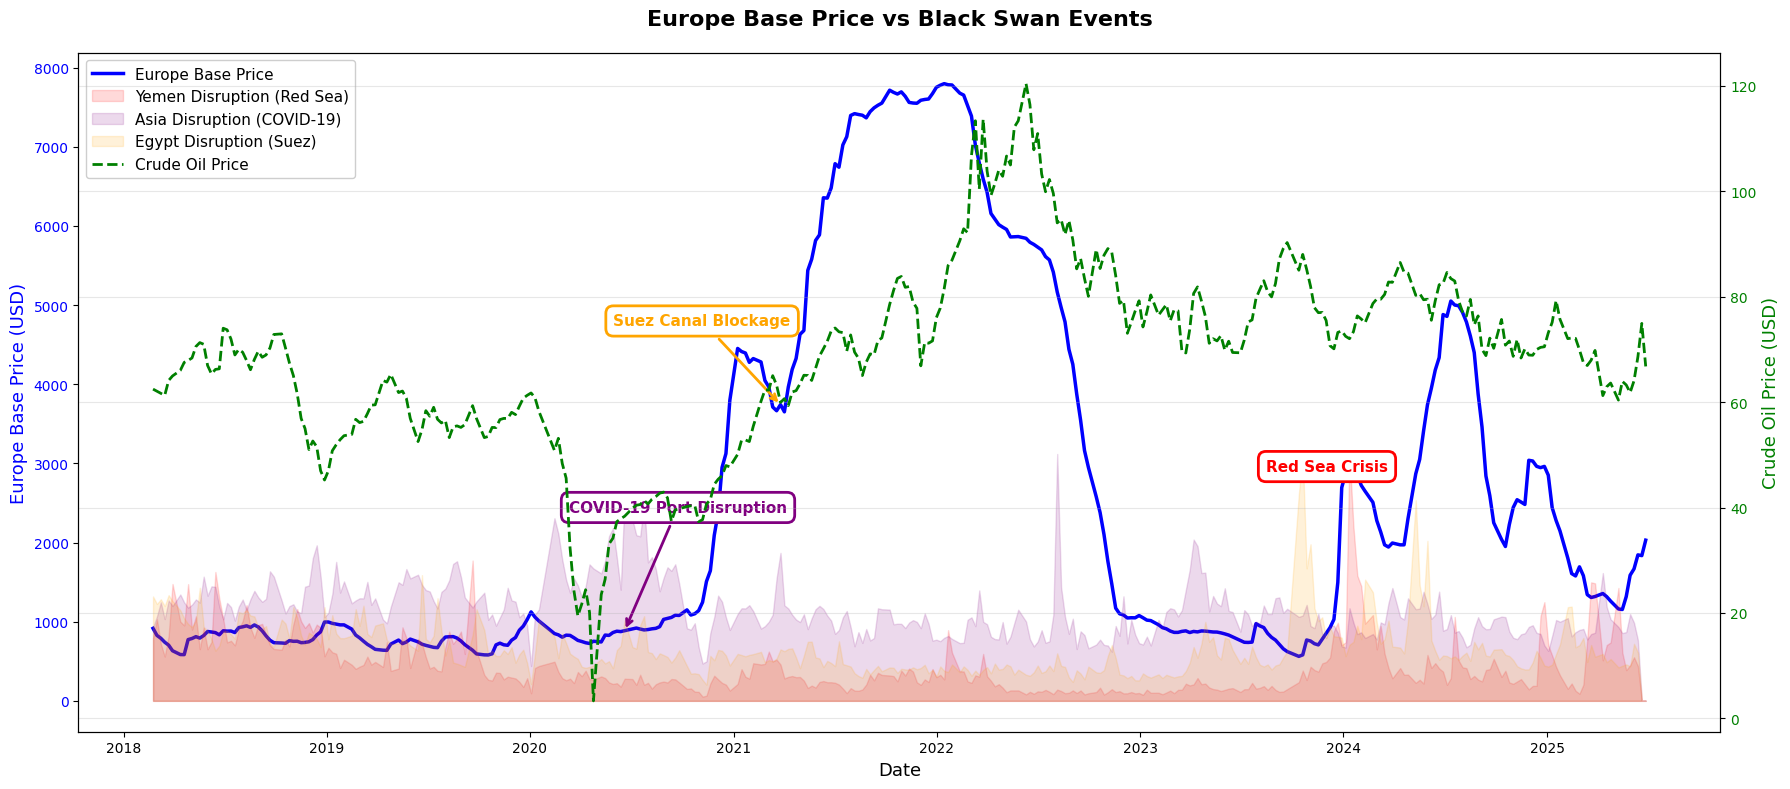

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(18, 8))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=13)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=13)
ax1.plot(df_model_data.index, df_model_data['Europe_Base_Price'], 
         color=color1, linewidth=2.5, label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis: Crude Oil Price
if 'crude_oil_price' in df_model_data.columns:
    ax2 = ax1.twinx()
    color2 = 'green'
    ax2.set_ylabel('Crude Oil Price (USD)', color=color2, fontsize=13)
    ax2.plot(df_model_data.index, df_model_data['crude_oil_price'], 
             color=color2, linewidth=2, linestyle='--', label='Crude Oil Price')
    ax2.tick_params(axis='y', labelcolor=color2)

# Plot key disruption features

# --- Yemen Disruption (Unchanged) ---
if 'yemen_disruption' in df_model_data.columns:
    yemen_max = df_model_data['yemen_disruption'].max()
    if yemen_max > 0:
        yemen_normalized = (df_model_data['yemen_disruption'] / yemen_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, yemen_normalized, 
                        color='red', alpha=0.15, label='Yemen Disruption (Red Sea)', zorder=2)

# --- Asia Disruption (Unchanged) ---
if 'asia_disruption' in df_model_data.columns:
    asia_max = df_model_data['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_model_data['asia_disruption'] / asia_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, asia_normalized, 
                        color='purple', alpha=0.15, label='Asia Disruption (COVID-19)', zorder=2)

# --- Egypt Disruption (Unchanged) ---
if 'egypt_disruption' in df_model_data.columns:
    egypt_max = df_model_data['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_model_data['egypt_disruption'] / egypt_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, egypt_normalized, 
                        color='orange', alpha=0.15, label='Egypt Disruption (Suez)', zorder=2)

# --- Annotations for major events ---

# --- Annotation for COVID-19 (Unchanged) ---
covid_peak = df_model_data[(df_model_data.index >= '2020-03-01') & (df_model_data.index <= '2021-12-31')]
if not covid_peak.empty and 'asia_disruption' in covid_peak.columns:
    covid_max_idx = covid_peak['asia_disruption'].idxmax() 
    covid_price = covid_peak.loc[covid_max_idx, 'Europe_Base_Price']
    ax1.annotate('COVID-19 Port Disruption', xy=(covid_max_idx, covid_price),
                xytext=(covid_max_idx - pd.Timedelta(days=100), covid_price + 1500),
                arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                fontsize=11, fontweight='bold', color='purple',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='purple', linewidth=2))

# ===================================================================
# FIXED SECTION
# This now finds the Friday *within* the blockage week (2021-03-23 to 2021-03-29)
# instead of looking for the exact (non-existent) start date.
# ===================================================================
suez_start_date = pd.Timestamp('2021-03-23')
suez_end_date = pd.Timestamp('2021-03-29')

# Find the row(s) *within* that week
suez_data_slice = df_model_data.loc[suez_start_date:suez_end_date]

if not suez_data_slice.empty:
    # Get the actual Friday index and price from that slice
    suez_friday_date = suez_data_slice.index[0] # This will be '2021-03-26'
    suez_price_point = suez_data_slice['Europe_Base_Price'].iloc[0] # Get price from that row

    # Point the arrow at the *actual* data point
    ax1.annotate('Suez Canal Blockage', xy=(suez_friday_date, suez_price_point),
                xytext=(suez_friday_date - pd.Timedelta(days=300), suez_price_point + 1000), 
                arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                fontsize=11, fontweight='bold', color='orange',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', linewidth=2))
# ===================================================================

# --- Annotation for Red Sea Crisis (Unchanged) ---
red_sea_start = pd.Timestamp('2023-10-20')
if any(df_model_data.index >= red_sea_start):
    red_sea_data = df_model_data[df_model_data.index >= red_sea_start]
    if not red_sea_data.empty and 'yemen_disruption' in red_sea_data.columns:
        red_sea_max_idx = red_sea_data['yemen_disruption'].idxmax()
        red_sea_price = red_sea_data.loc[red_sea_max_idx, 'Europe_Base_Price']
        ax1.annotate('Red Sea Crisis', xy=(red_sea_max_idx, red_sea_price),
                    xytext=(red_sea_max_idx - pd.Timedelta(days=150), red_sea_price - 200),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold', color='red',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', linewidth=2))

plt.title('Europe Base Price vs Black Swan Events', fontsize=16, fontweight='bold', pad=20)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
if 'crude_oil_price' in df_model_data.columns:
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11, framealpha=0.95)
else:
    ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Predictive Correlation Analysis

**Most important analysis** - showing which lagged features correlate with future price movements.

PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE

Analyzing 17 lagged features

Features ranked by correlation strength with price_1w_ahead:
crude_oil_price_lag_1                0.451035
crude_oil_price_lag_2                0.433252
yemen_disruption_lag_1              -0.217692
yemen_disruption_lag_2              -0.223932
maritime_conflict_events_lag_1      -0.228434
maritime_conflict_events_lag_2      -0.236028
black_swan_candidate_events_lag_1   -0.272435
black_swan_candidate_events_lag_2   -0.273569
asia_disruption_lag_6               -0.337270
egypt_disruption_lag_2              -0.340655
asia_disruption_lag_5               -0.342952
egypt_disruption_lag_1              -0.344647
asia_disruption_lag_4               -0.347218
europe_disruption_lag_1             -0.384646
europe_disruption_lag_2             -0.395910
extreme_crisis_events_lag_1         -0.434308
extreme_crisis_events_lag_2         -0.450322
Name: price_1w_ahead, dtype: float64


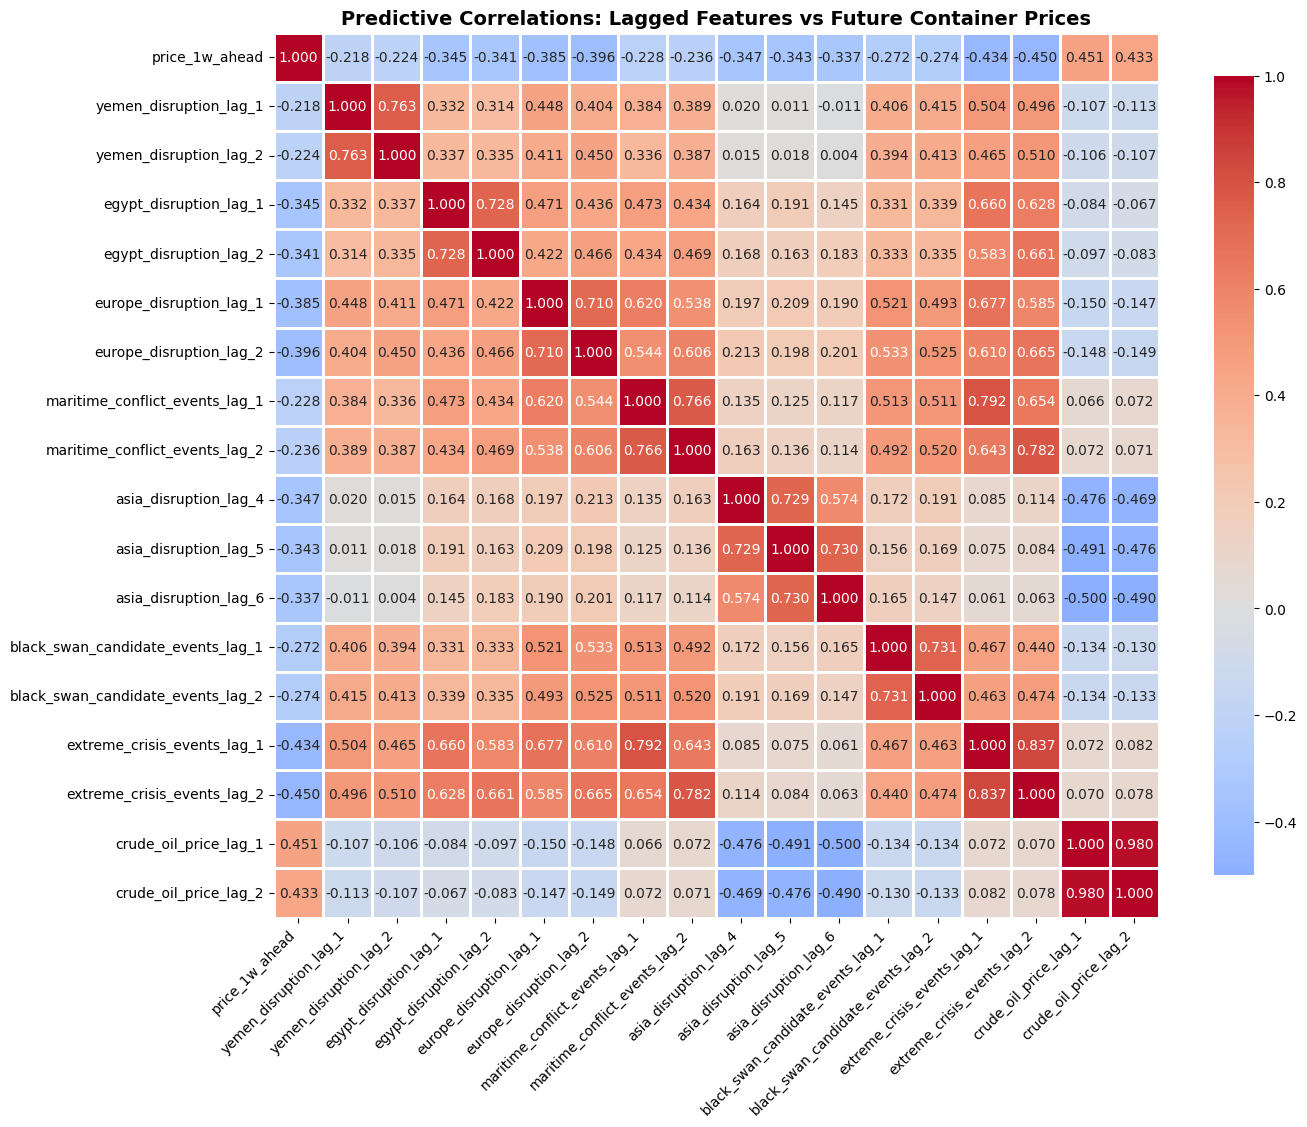


INTERPRETATION GUIDE
• Strong correlation (|r| > 0.5): Feature strongly predicts price changes
• Moderate correlation (|r| > 0.3): Useful predictive feature
• Weak correlation (|r| < 0.2): Little predictive value

This validates which lagged disruption features are truly predictive!


In [7]:
# Correlation matrix for target and lagged features
lag_features = [col for col in df_model_data.columns if '_lag_' in col]

if len(lag_features) == 0:
    print("ERROR: No lagged features found! Check Step 3 feature engineering.")
else:
    predictive_features = ['price_1w_ahead'] + lag_features
    correlation_data = df_model_data[predictive_features].corr()
    target_correlations = correlation_data['price_1w_ahead'].drop('price_1w_ahead')
    
    print("=" * 70)
    print("PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE")
    print("=" * 70)
    print(f"\nAnalyzing {len(lag_features)} lagged features")
    print("\nFeatures ranked by correlation strength with price_1w_ahead:")
    print(target_correlations.sort_values(ascending=False))
    
    # Heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Predictive Correlations: Lagged Features vs Future Container Prices', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("INTERPRETATION GUIDE")
    print("=" * 70)
    print("• Strong correlation (|r| > 0.5): Feature strongly predicts price changes")
    print("• Moderate correlation (|r| > 0.3): Useful predictive feature") 
    print("• Weak correlation (|r| < 0.2): Little predictive value")
    print("\nThis validates which lagged disruption features are truly predictive!")

## Step 6: Stationarity Test

Test if the time series is stationary (statistical properties stable over time). Many models assume stationarity.

In [8]:
def check_stationarity(timeseries, column_name):
    print(f"\n=== Stationarity Analysis for {column_name} ===")
    
    # Augmented Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                        index=['Test Statistic', 'p-value', 'Lags Used', 'Observations'])
    
    print('\nAugmented Dickey-Fuller Test Results:')
    print(dfoutput)
    
    print('\nCritical Values:')
    for key, value in dftest[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('\nInterpretation:')
    if dfoutput['p-value'] <= 0.05:
        print(f"  p-value = {dfoutput['p-value']:.4f} (< 0.05)")
        print("  Result: Series is STATIONARY (good for modeling)")
    else:
        print(f"  p-value = {dfoutput['p-value']:.4f} (> 0.05)")
        print("  Result: Series is NON-STATIONARY (may need differencing)")

# Check Europe Base Price stationarity
check_stationarity(df_freight['Europe_Base_Price'], 'Europe Base Price')

# Check crude oil price stationarity if available
if has_oil and df_oil_weekly is not None:
    check_stationarity(df_oil_weekly['crude_oil_price'].dropna(), 'Crude Oil Price')


=== Stationarity Analysis for Europe Base Price ===

Augmented Dickey-Fuller Test Results:
Test Statistic     -2.088145
p-value             0.249308
Lags Used          17.000000
Observations      367.000000
dtype: float64

Critical Values:
  1%: -3.448
  5%: -2.869
  10%: -2.571

Interpretation:
  p-value = 0.2493 (> 0.05)
  Result: Series is NON-STATIONARY (may need differencing)

=== Stationarity Analysis for Crude Oil Price ===

Augmented Dickey-Fuller Test Results:
Test Statistic     -1.867348
p-value             0.347574
Lags Used           0.000000
Observations      391.000000
dtype: float64

Critical Values:
  1%: -3.447
  5%: -2.869
  10%: -2.571

Interpretation:
  p-value = 0.3476 (> 0.05)
  Result: Series is NON-STATIONARY (may need differencing)


## Step 6: Disruption Events Analysis

Analyze geopolitical disruption patterns and their relationship to container prices.

GEOPOLITICAL DISRUPTION ANALYSIS

GDELT data: 407 weekly records


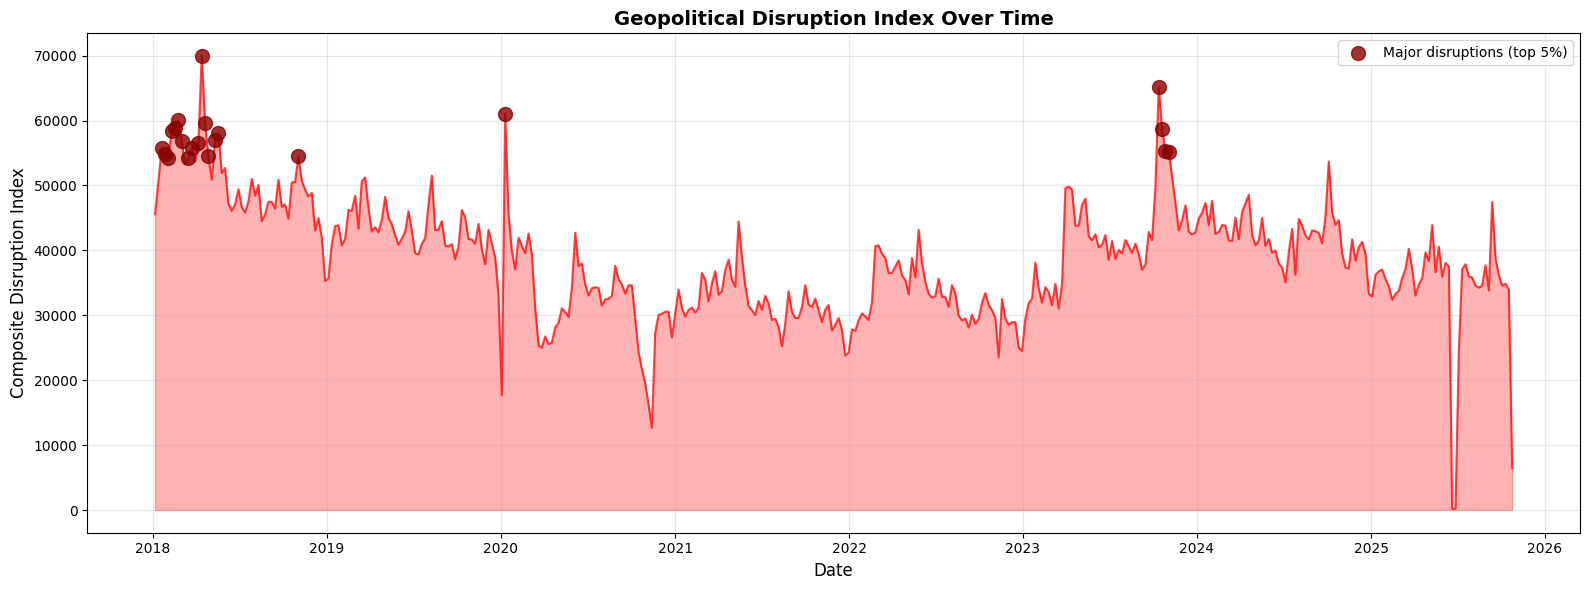


TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)
            composite_disruption_index  maritime_conflict_events  extreme_crisis_events  black_swan_candidate_events
date                                                                                                                
2018-04-13                     69935.3                     27370                 205721                           20
2023-10-13                     65123.6                     23782                 193286                            8
2020-01-10                     61074.9                     25038                 178533                            9
2018-02-23                     60033.1                     34021                 166064                           19
2018-04-20                     59660.4                     27749                 171107                            9
2018-02-16                     58837.4                     33841                 162253                           23
2023-10-

In [9]:
if has_news:
    # Create composite disruption index
    df_news['composite_disruption_index'] = (
        df_news['extreme_crisis_events'] * 0.3 +
        df_news['maritime_conflict_events'] * 0.3 +
        df_news['black_swan_candidate_events'] * 0.4
    )
    
    print("=" * 70)
    print("GEOPOLITICAL DISRUPTION ANALYSIS")
    print("=" * 70)
    print(f"\nGDELT data: {len(df_news)} weekly records")
    
    # Disruption over time
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(df_news.index, df_news['composite_disruption_index'], 
            linewidth=1.5, color='red', alpha=0.7)
    ax.fill_between(df_news.index, 0, df_news['composite_disruption_index'], 
                     alpha=0.3, color='red')
    
    # Highlight major disruptions
    threshold_95 = df_news['composite_disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['composite_disruption_index'] > threshold_95]
    ax.scatter(major_disruptions.index, major_disruptions['composite_disruption_index'],
               color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    
    ax.set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Composite Disruption Index', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top disruption weeks
    print("\n" + "=" * 70)
    print("TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("=" * 70)
    top_disruptions = df_news.nlargest(10, 'composite_disruption_index')[[
        'composite_disruption_index', 'maritime_conflict_events', 
        'extreme_crisis_events', 'black_swan_candidate_events'
    ]]
    print(top_disruptions.to_string())
    
    print("\nExpected major events (2018-2025):")
    print("  • COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  • Suez Canal blockage (March 2021): Ever Given incident")
    print("  • Russia-Ukraine war (Feb 2022+): Grain exports, fuel")
    print("  • Israel-Hamas conflict (Oct 2023+): Red Sea disruptions")
else:
    print("No disruption data available.")

## Step 7: Summary and Next Steps

In [10]:
print("=" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 70)

# Get lagged features count
lag_features_final = [col for col in df_model_data.columns if '_lag_' in col]

print(f"\nModeling Dataset Ready:")
print(f"  • {len(df_model_data)} training samples")
print(f"  • {len(lag_features_final)} predictive lagged features")
print(f"  • Target: price_1w_ahead (1-week ahead prediction)")

print(f"\nKey Features Engineered:")
print(f"  • Origin/Route lags: Yemen, Egypt, Europe, Maritime (1-2 weeks)")
print(f"  • Destination lags: Asia disruption (4-6 weeks)")
print(f"  • Global lags: Black swan events (1-2 weeks)")
print(f"  • Oil price lags: Crude oil prices (1-2 weeks)")

if len(lag_features_final) > 0:
    # Recalculate target correlations for summary
    predictive_features = ['price_1w_ahead'] + lag_features_final
    correlation_data_summary = df_model_data[predictive_features].corr()
    target_correlations_summary = correlation_data_summary['price_1w_ahead'].drop('price_1w_ahead')
    
    print(f"\nTop 5 Predictive Features:")
    top_features = target_correlations_summary.abs().sort_values(ascending=False).head(5)
    for feature, _ in top_features.items():
        corr_val = target_correlations_summary[feature]
        direction = "increases" if corr_val > 0 else "decreases"
        print(f"  • {feature}: {corr_val:.3f} (predicts price {direction})")
else:
    print(f"\nWARNING: No lagged features found in final dataset!")

print(f"\nData Quality:")
print(f"  • Price range: ${df_model_data['Europe_Base_Price'].min():.2f} to ${df_model_data['Europe_Base_Price'].max():.2f}")
print(f"  • Price volatility (std): ${df_model_data['Europe_Base_Price'].std():.2f}")
if 'crude_oil_price' in df_model_data.columns:
    print(f"  • Oil price range: ${df_model_data['crude_oil_price'].min():.2f} to ${df_model_data['crude_oil_price'].max():.2f}")
print(f"  • Missing values in final dataset: {df_model_data.isnull().sum().sum()}")

print("\n" + "=" * 70)

# Save the processed dataset for modeling
df_model_data.to_csv('processed_model_data.csv')
print("\n✓ Saved processed dataset to 'processed_model_data.csv'")

FEATURE ENGINEERING SUMMARY

Modeling Dataset Ready:
  • 353 training samples
  • 17 predictive lagged features
  • Target: price_1w_ahead (1-week ahead prediction)

Key Features Engineered:
  • Origin/Route lags: Yemen, Egypt, Europe, Maritime (1-2 weeks)
  • Destination lags: Asia disruption (4-6 weeks)
  • Global lags: Black swan events (1-2 weeks)
  • Oil price lags: Crude oil prices (1-2 weeks)

Top 5 Predictive Features:
  • crude_oil_price_lag_1: 0.451 (predicts price increases)
  • extreme_crisis_events_lag_2: -0.450 (predicts price decreases)
  • extreme_crisis_events_lag_1: -0.434 (predicts price decreases)
  • crude_oil_price_lag_2: 0.433 (predicts price increases)
  • europe_disruption_lag_2: -0.396 (predicts price decreases)

Data Quality:
  • Price range: $562.00 to $7797.00
  • Price volatility (std): $2300.35
  • Oil price range: $3.32 to $120.43
  • Missing values in final dataset: 0


✓ Saved processed dataset to 'processed_model_data.csv'
